## VGG Models

In [27]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.optim as optim
from tqdm import tqdm

In [2]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


### Data Preparation

In [30]:
class VehicleDataset(Dataset):
    
    def __init__(self, path):
        data = np.load(path)
        self.images = data["images"]
        self.labels = data["labels"]
        print("Images shape:", self.images.shape)
        print("Labels shape:", self.labels.shape)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        label = torch.tensor(label, dtype=torch.long)

        #mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        #std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        #image = (image - mean) / std
        
        return image, label

In [61]:
dataset = VehicleDataset('../dataset/stanford_cars_dataset.npz')

batch_size = 32
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = int(len(dataset) - train_size - val_size)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Images shape: (8144, 112, 112, 3)
Labels shape: (8144, 1)


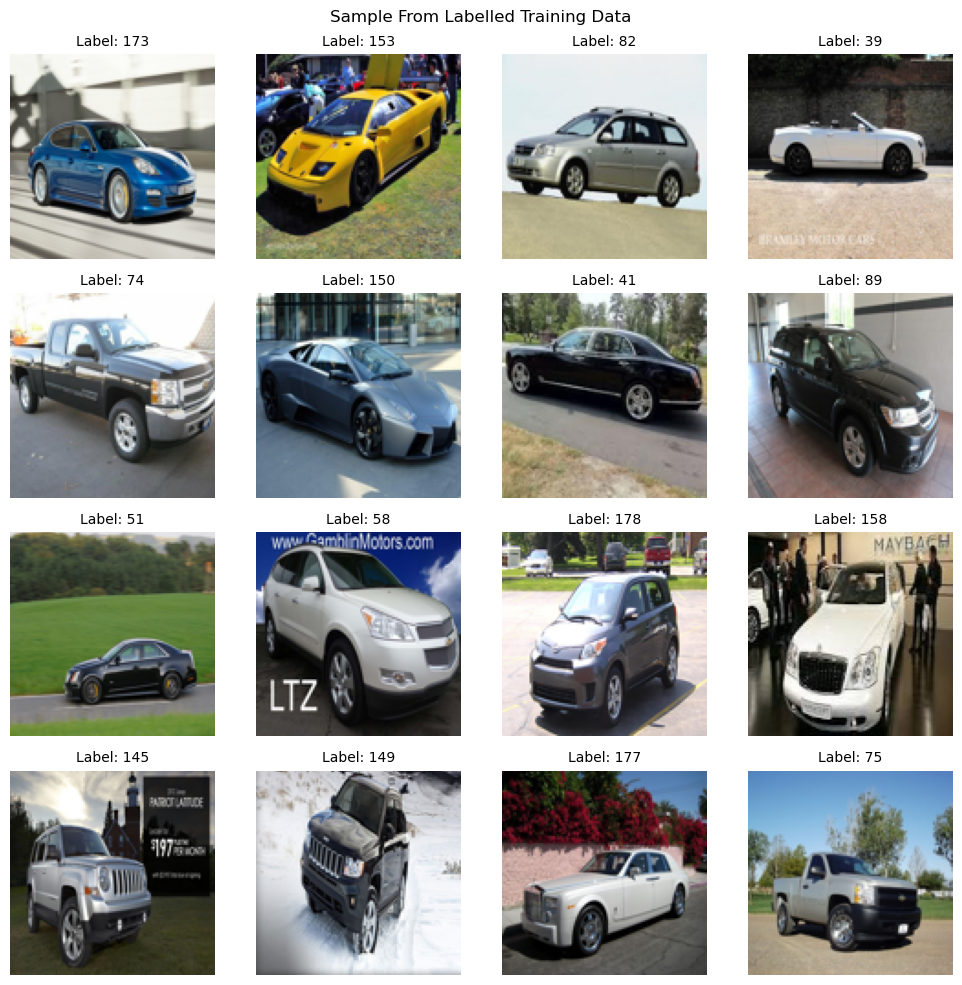

In [62]:
for images, labels in train_loader:
    break 

# Create figure
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

for i in range(16):
    img = images[i].permute(1, 2, 0).numpy() 
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {labels[i].item()}", fontsize=10)
    axes[i].axis("off")

plt.suptitle("Sample From Labelled Training Data")
plt.tight_layout(rect=[0, 0, 1, 1]) 
plt.show()

### VGG Models

In [63]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BasicBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x

In [64]:
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        self.layer1 = BasicBlock(3, 112)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer2 = BasicBlock(112, 128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer3 = BasicBlock(128, 256)
        self.layer4 = BasicBlock(256, 256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer5 = BasicBlock(256, 512)
        self.layer6 = BasicBlock(512, 512)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer7 = BasicBlock(512, 512)
        self.layer8 = BasicBlock(512, 512)
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.classifier = nn.Sequential(
            nn.Linear(4608, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 196)
        )
    def forward(self, x):
        x = self.layer1(x)
        x = self.maxpool1(x)
        x = self.layer2(x)
        x = self.maxpool2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.maxpool3(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.maxpool4(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.maxpool5(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

### Training

In [65]:
def train_model(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    num_epochs = 15
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
    
        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels[:,0].to(device) - 1

            # Forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Metrics
            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = correct / total

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}")
    
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels[:,0].to(device) - 1
            
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_acc = correct / total
        print(f'Validation Acc: {val_acc:.4f}')

In [66]:
model = VGG11().to(device)
train_model(model)

100%|██████████| 179/179 [00:27<00:00,  6.54it/s]


Epoch 1/15 - Loss: 5.2796 - Accuracy: 0.0040
Validation Acc: 0.0025


100%|██████████| 179/179 [00:26<00:00,  6.68it/s]


Epoch 2/15 - Loss: 5.2731 - Accuracy: 0.0060
Validation Acc: 0.0068


100%|██████████| 179/179 [00:27<00:00,  6.45it/s]


Epoch 3/15 - Loss: 5.2135 - Accuracy: 0.0068
Validation Acc: 0.0080


100%|██████████| 179/179 [00:37<00:00,  4.78it/s]


Epoch 4/15 - Loss: 5.1622 - Accuracy: 0.0105
Validation Acc: 0.0080


100%|██████████| 179/179 [00:29<00:00,  6.05it/s]


Epoch 5/15 - Loss: 5.1366 - Accuracy: 0.0107
Validation Acc: 0.0098


100%|██████████| 179/179 [00:26<00:00,  6.66it/s]


Epoch 6/15 - Loss: 5.1171 - Accuracy: 0.0123
Validation Acc: 0.0111


100%|██████████| 179/179 [00:26<00:00,  6.71it/s]


Epoch 7/15 - Loss: 5.0960 - Accuracy: 0.0123
Validation Acc: 0.0104


100%|██████████| 179/179 [00:26<00:00,  6.68it/s]


Epoch 8/15 - Loss: 5.0769 - Accuracy: 0.0133
Validation Acc: 0.0129


100%|██████████| 179/179 [00:25<00:00,  7.16it/s]


Epoch 9/15 - Loss: 5.0374 - Accuracy: 0.0172
Validation Acc: 0.0166


100%|██████████| 179/179 [00:14<00:00, 12.42it/s]


Epoch 10/15 - Loss: 4.9781 - Accuracy: 0.0189
Validation Acc: 0.0154


100%|██████████| 179/179 [00:17<00:00, 10.14it/s]


Epoch 11/15 - Loss: 4.9016 - Accuracy: 0.0223
Validation Acc: 0.0190


100%|██████████| 179/179 [00:17<00:00, 10.28it/s]


Epoch 12/15 - Loss: 4.7943 - Accuracy: 0.0275
Validation Acc: 0.0172


100%|██████████| 179/179 [00:27<00:00,  6.60it/s]


Epoch 13/15 - Loss: 4.6832 - Accuracy: 0.0328
Validation Acc: 0.0252


100%|██████████| 179/179 [00:26<00:00,  6.65it/s]


Epoch 14/15 - Loss: 4.5306 - Accuracy: 0.0479
Validation Acc: 0.0252


100%|██████████| 179/179 [00:27<00:00,  6.61it/s]


Epoch 15/15 - Loss: 4.3752 - Accuracy: 0.0588
Validation Acc: 0.0301


### Testing

In [67]:
def test_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels[:,0].to(device) - 1 
            
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

    # Concatenate all predictions and labels if needed for further analysis
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    
    return accuracy, all_preds, all_labels

In [68]:
test_model(model, test_loader, device)

Test Accuracy: 0.0294


(0.029411764705882353,
 tensor([158,  85, 158, 164, 159,   6,  15, 186, 115, 131,  85, 151, 159,  77,
         118, 115, 123, 119,  45,   2,   5, 164, 101,  15, 164,  21,  20, 132,
         180,  30,   5, 164, 105,  72,  45,   2,  21,  46, 176, 136, 111,  44,
          52, 190,  21, 146,  81,  33, 179,  70, 176,  81,  20, 119,  57,  45,
          20, 125,  19,   5, 168, 164, 140,  72, 132, 157, 131, 180, 164, 131,
         136, 123,  13,   5,  44, 112,  32,  81, 122,  32,   8,  24, 122, 158,
          24, 115,  24, 178, 164,  70,  20, 158,  46, 164, 151, 158, 115, 128,
          21, 158, 115, 115, 179, 190,   8,  92, 119, 186, 132, 158,   5,  92,
          61,   5, 179, 164,  45, 190, 141,  52, 141,  92, 155, 119, 119, 119,
         190,  19, 112,   8, 128, 164,   2,  19, 161,  57,  46,  20,   2,  24,
         144,  93,  68,  19,  70, 164, 103,  46, 164, 159,  81, 123,  21,  44,
          32, 105,   6, 186,  29, 128,  15, 131, 105,  19, 180, 132, 115, 115,
         190, 164,  25, 125, 

In [34]:
class VGG13(nn.Module):
    def __init__(self):
        super(VGG13, self).__init__()
        self.layer1 = BasicBlock(3, 64)
        self.layer11 = BasicBlock(64, 64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer2 = BasicBlock(64, 128)
        self.layer22 = BasicBlock(128, 128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer3 = BasicBlock(128, 256)
        self.layer4 = BasicBlock(256, 256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer5 = BasicBlock(256, 512)
        self.layer6 = BasicBlock(512, 512)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer7 = BasicBlock(512, 512)
        self.layer8 = BasicBlock(512, 512)
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 196)
        )
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer11(x)
        x = self.maxpool1(x)
        x = self.layer2(x)
        x = self.layer22(x)
        x = self.maxpool2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.maxpool3(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.maxpool4(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.maxpool5(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [35]:
model = VGG13().to(device)
train_model(model)

Epoch 1/5 - Loss: 5.2804 - Accuracy: 0.0077
Validation Acc: 0.0025
Epoch 2/5 - Loss: 5.2772 - Accuracy: 0.0098
Validation Acc: 0.0025
Epoch 3/5 - Loss: 5.2761 - Accuracy: 0.0098
Validation Acc: 0.0025
Epoch 4/5 - Loss: 5.2752 - Accuracy: 0.0098
Validation Acc: 0.0025
Epoch 5/5 - Loss: 5.2744 - Accuracy: 0.0098
Validation Acc: 0.0025


In [36]:
test_model(model, test_loader, device)

Test Accuracy: 0.0098


(0.00980392156862745,
 tensor([118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 1

In [37]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.layer1 = BasicBlock(3, 64)
        self.layer11 = BasicBlock(64, 64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer2 = BasicBlock(64, 128)
        self.layer22 = BasicBlock(128, 128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer3 = BasicBlock(128, 256)
        self.layer4 = BasicBlock(256, 256)
        self.layer41 = BasicBlock(256, 256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer5 = BasicBlock(256, 512)
        self.layer6 = BasicBlock(512, 512)
        self.layer61 = BasicBlock(512, 512)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer7 = BasicBlock(512, 512)
        self.layer8 = BasicBlock(512, 512)
        self.layer81 = BasicBlock(512, 512)
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 196)
        )
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer11(x)
        x = self.maxpool1(x)
        x = self.layer2(x)
        x = self.layer22(x)
        x = self.maxpool2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer41(x)
        x = self.maxpool3(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer61(x)
        x = self.maxpool4(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer81(x)
        x = self.maxpool5(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [38]:
model = VGG16().to(device)
train_model(model)

Epoch 1/5 - Loss: 5.2812 - Accuracy: 0.0075
Validation Acc: 0.0025
Epoch 2/5 - Loss: 5.2773 - Accuracy: 0.0098
Validation Acc: 0.0025
Epoch 3/5 - Loss: 5.2763 - Accuracy: 0.0098
Validation Acc: 0.0025
Epoch 4/5 - Loss: 5.2754 - Accuracy: 0.0098
Validation Acc: 0.0025
Epoch 5/5 - Loss: 5.2738 - Accuracy: 0.0098
Validation Acc: 0.0025


In [39]:
test_model(model, test_loader, device)

Test Accuracy: 0.0098


(0.00980392156862745,
 tensor([118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 1

In [42]:
class VGG19(nn.Module):
    def __init__(self):
        super(VGG19, self).__init__()
        self.layer1 = BasicBlock(3, 64)
        self.layer11 = BasicBlock(64, 64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer2 = BasicBlock(64, 128)
        self.layer22 = BasicBlock(128, 128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer3 = BasicBlock(128, 256)
        self.layer4 = BasicBlock(256, 256)
        self.layer41 = BasicBlock(256, 256)
        self.layer42 = BasicBlock(256, 256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer5 = BasicBlock(256, 512)
        self.layer6 = BasicBlock(512, 512)
        self.layer61 = BasicBlock(512, 512)
        self.layer62 = BasicBlock(512, 512)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.layer7 = BasicBlock(512, 512)
        self.layer8 = BasicBlock(512, 512)
        self.layer81 = BasicBlock(512, 512)
        self.layer82 = BasicBlock(512, 512)
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 196)
        )
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer11(x)
        x = self.maxpool1(x)
        x = self.layer2(x)
        x = self.layer22(x)
        x = self.maxpool2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer41(x)
        x = self.layer42(x)
        x = self.maxpool3(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer61(x)
        x = self.layer62(x)
        x = self.maxpool4(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer81(x)
        x = self.layer82(x)
        x = self.maxpool5(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [43]:
model = VGG19().to(device)
train_model(model)

Epoch 1/5 - Loss: 5.2808 - Accuracy: 0.0053
Validation Acc: 0.0025
Epoch 2/5 - Loss: 5.2774 - Accuracy: 0.0098
Validation Acc: 0.0025
Epoch 3/5 - Loss: 5.2764 - Accuracy: 0.0098
Validation Acc: 0.0025
Epoch 4/5 - Loss: 5.2754 - Accuracy: 0.0098
Validation Acc: 0.0025
Epoch 5/5 - Loss: 5.2745 - Accuracy: 0.0098
Validation Acc: 0.0025


In [44]:
test_model(model, test_loader, device)

Test Accuracy: 0.0098


(0.00980392156862745,
 tensor([118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
         118, 118, 118, 118, 1